## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

# imbalance data mitigation
from imblearn.over_sampling import SVMSMOTE

from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import train_test_split,ShuffleSplit, RandomizedSearchCV, GridSearchCV 

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load train data
train_data = pd.read_csv('./training.csv')
train_data.head(3)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2


In [3]:
# load test data
test_data = pd.read_csv('./Test.csv')
test_data.head(3)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2


**Inspect Train Data**

In [4]:
# check for nulls and data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


C:\Users\lv974m\AppData\Local\Continuum\anaconda3\envs\pyproj\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


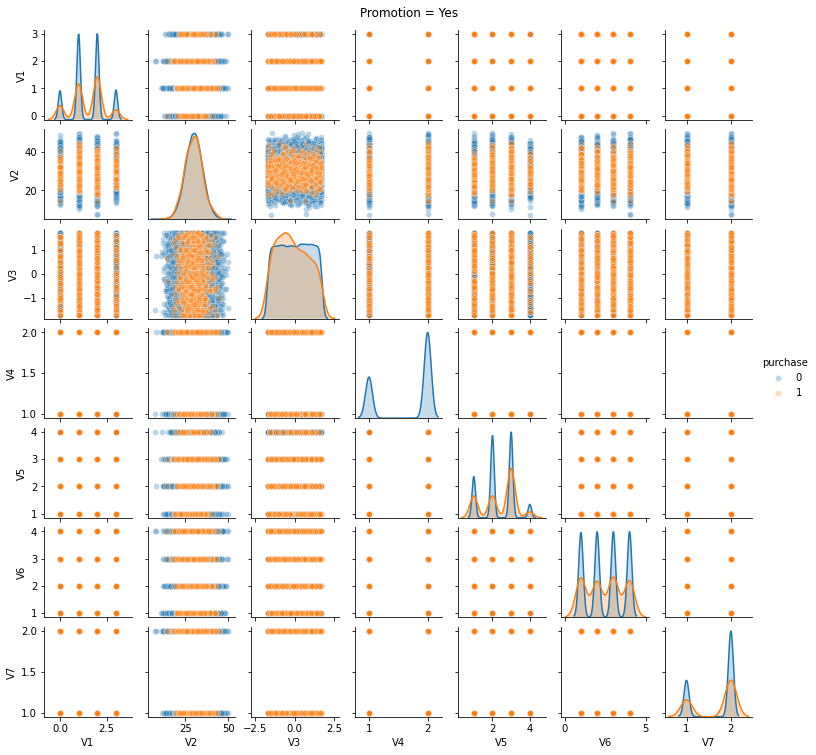

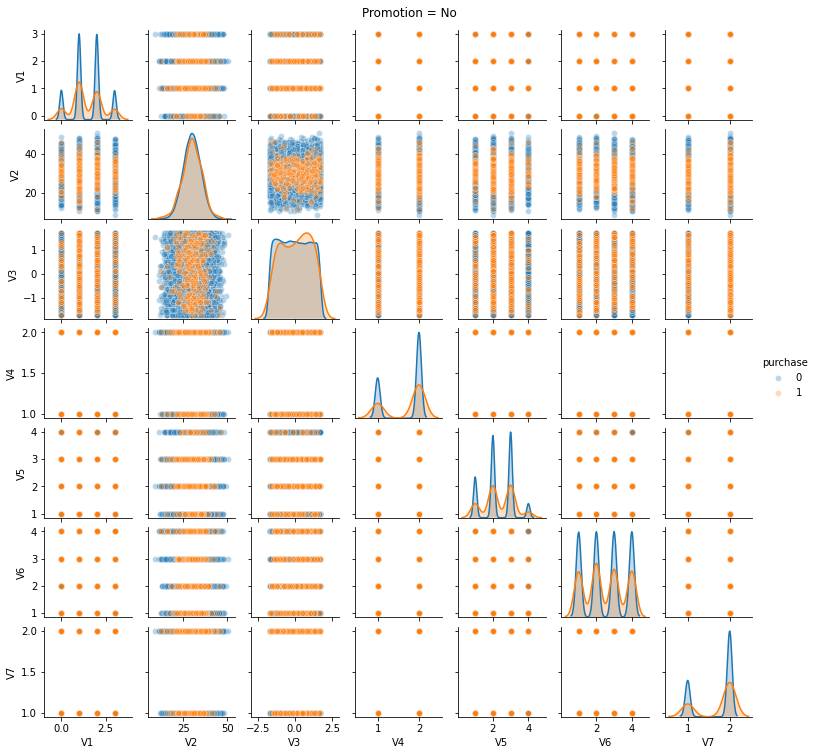

In [5]:
# Produce Scatter Matrix / Pairplot to undesrtand data description visually
# analysis for Promotion = Yes

for i in ['Yes', 'No']:
    sns.pairplot(train_data.query('Promotion == @i').iloc[:, 2:]
                 ,hue= 'purchase'
                 ,height = 1.5
                 ,plot_kws= {'alpha': 0.3})
    plt.suptitle(f'Promotion = {i}')
    plt.subplots_adjust(top=.95);


In [6]:
# check distribution of promoted/ not promoted
a = len(train_data.query('Promotion == "Yes"'))
b = len(train_data.query('Promotion == "No"'))
print(f'Row Count with promotions {a}')
print(f'Row Count w/o promotion  {b}')

Row Count with promotions 42364
Row Count w/o promotion  42170


**Benchmark Model: All consumer recieves promotion**

In [7]:
# create benchmark model; all consumer recieves promotion

def promotion_all(df):
    '''
    input:    dataframe containing columns X_train or X_test
    output:   numpy array of prootions 
    '''
    promotion = ['Yes' for i in range(len(df))]
    
    # convert list to numpy array
    promotion = np.array(promotion)
    
    return promotion

In [8]:
# RESULTS for benchmark model 
test_results(promotion_all)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

**Build ML Model:**
> XGBoost Model for individuals who purchased after receiving a promotion

In [9]:
# generate y label 
# (need to recode this, takes too much time)

label = []

for i, row in train_data.iterrows():
    if (row['Promotion']=='Yes') and (row['purchase'] == 1):
        label.append(1)
    else:
        label.append(0)

train_data['label'] = label

In [10]:
#inspect data
train_data.query('label ==1').tail(3)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,label
84314,125828,Yes,1,2,33.966419,1.605406,2,1,3,2,1
84388,125954,Yes,1,2,31.100225,-1.165083,2,3,2,1,1
84425,126005,Yes,1,2,32.146965,1.691984,2,3,4,2,1


In [11]:
# test distribution of labels
train_data.label.value_counts()

0    83813
1      721
Name: label, dtype: int64

In [12]:
# inbalance of labels was expected; try imblancelearn SVMSMOTE

X = (train_data.query('Promotion == "Yes"')
     .iloc[:, 3:]
     .drop('label', axis=1))
y = (train_data.query('Promotion == "Yes"')['label'])

# use smote svm to manage imbalance
svms = SVMSMOTE(random_state=42)
X, y = svms.fit_resample(X, y)

In [13]:
# check for new ratio
y.value_counts()

0    41643
1    23226
Name: label, dtype: int64

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# run XGBoost Classifier
clf = XGBClassifier(random_state=42,
                    learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1)

In [16]:
# fit model
#clf.fit(X_train,y_train)
clf.fit(X_train,
        y_train,
        early_stopping_rounds=30,
        eval_metric='auc', # for imbalnced data
        eval_set=[(X_train, y_train), (X_test, y_test)])
    
#predict
y_pred = clf.predict(X_test)

[0]	validation_0-auc:0.79446	validation_1-auc:0.78988
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82395	validation_1-auc:0.81828
[2]	validation_0-auc:0.83573	validation_1-auc:0.83008
[3]	validation_0-auc:0.83899	validation_1-auc:0.83356
[4]	validation_0-auc:0.83847	validation_1-auc:0.83272
[5]	validation_0-auc:0.84317	validation_1-auc:0.83865
[6]	validation_0-auc:0.84990	validation_1-auc:0.84598
[7]	validation_0-auc:0.84800	validation_1-auc:0.84338
[8]	validation_0-auc:0.85472	validation_1-auc:0.84967
[9]	validation_0-auc:0.85621	validation_1-auc:0.85187
[10]	validation_0-auc:0.85972	validation_1-auc:0.85515
[11]	validation_0-auc:0.86151	validation_1-auc:0.85701
[12]	validation_0-auc:0.86896	validation_1-auc:0.86408
[13]	validation_0-auc:0.87095	validation_1-auc:0.86601
[14]	validation_0-auc:0.87113	validation_1-auc:0.86617
[15]	validation_0-auc:0.8722

[146]	validation_0-auc:0.98930	validation_1-auc:0.98552
[147]	validation_0-auc:0.98942	validation_1-auc:0.98567
[148]	validation_0-auc:0.98964	validation_1-auc:0.98587
[149]	validation_0-auc:0.98964	validation_1-auc:0.98586
[150]	validation_0-auc:0.98964	validation_1-auc:0.98585
[151]	validation_0-auc:0.98976	validation_1-auc:0.98592
[152]	validation_0-auc:0.98985	validation_1-auc:0.98601
[153]	validation_0-auc:0.98988	validation_1-auc:0.98602
[154]	validation_0-auc:0.98989	validation_1-auc:0.98604
[155]	validation_0-auc:0.98992	validation_1-auc:0.98605
[156]	validation_0-auc:0.98991	validation_1-auc:0.98602
[157]	validation_0-auc:0.98994	validation_1-auc:0.98604
[158]	validation_0-auc:0.99004	validation_1-auc:0.98615
[159]	validation_0-auc:0.99006	validation_1-auc:0.98619
[160]	validation_0-auc:0.99008	validation_1-auc:0.98620
[161]	validation_0-auc:0.99015	validation_1-auc:0.98628
[162]	validation_0-auc:0.99018	validation_1-auc:0.98630
[163]	validation_0-auc:0.99031	validation_1-auc:

[293]	validation_0-auc:0.99269	validation_1-auc:0.98797
[294]	validation_0-auc:0.99272	validation_1-auc:0.98795
[295]	validation_0-auc:0.99272	validation_1-auc:0.98794
[296]	validation_0-auc:0.99276	validation_1-auc:0.98796
[297]	validation_0-auc:0.99276	validation_1-auc:0.98796
[298]	validation_0-auc:0.99277	validation_1-auc:0.98797
[299]	validation_0-auc:0.99279	validation_1-auc:0.98797
[300]	validation_0-auc:0.99280	validation_1-auc:0.98798
[301]	validation_0-auc:0.99281	validation_1-auc:0.98796
[302]	validation_0-auc:0.99284	validation_1-auc:0.98798
[303]	validation_0-auc:0.99285	validation_1-auc:0.98799
[304]	validation_0-auc:0.99286	validation_1-auc:0.98800
[305]	validation_0-auc:0.99287	validation_1-auc:0.98800
[306]	validation_0-auc:0.99287	validation_1-auc:0.98799
[307]	validation_0-auc:0.99288	validation_1-auc:0.98800
[308]	validation_0-auc:0.99290	validation_1-auc:0.98802
[309]	validation_0-auc:0.99291	validation_1-auc:0.98804
[310]	validation_0-auc:0.99296	validation_1-auc:

[440]	validation_0-auc:0.99444	validation_1-auc:0.98827
[441]	validation_0-auc:0.99445	validation_1-auc:0.98825
[442]	validation_0-auc:0.99446	validation_1-auc:0.98825
[443]	validation_0-auc:0.99447	validation_1-auc:0.98825
[444]	validation_0-auc:0.99447	validation_1-auc:0.98827
[445]	validation_0-auc:0.99449	validation_1-auc:0.98826
[446]	validation_0-auc:0.99451	validation_1-auc:0.98826
[447]	validation_0-auc:0.99452	validation_1-auc:0.98826
[448]	validation_0-auc:0.99453	validation_1-auc:0.98825
[449]	validation_0-auc:0.99456	validation_1-auc:0.98828
[450]	validation_0-auc:0.99457	validation_1-auc:0.98826
[451]	validation_0-auc:0.99457	validation_1-auc:0.98827
[452]	validation_0-auc:0.99458	validation_1-auc:0.98827
[453]	validation_0-auc:0.99459	validation_1-auc:0.98827
[454]	validation_0-auc:0.99460	validation_1-auc:0.98828
Stopping. Best iteration:
[424]	validation_0-auc:0.99426	validation_1-auc:0.98830



In [17]:
# check scores
print(' Classification Report \n', classification_report(y_test, y_pred, zero_division=0))
print(' Confusion Matrix \n', confusion_matrix(y_test, y_pred))

 Classification Report 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     12512
           1       1.00      0.96      0.98      6949

    accuracy                           0.98     19461
   macro avg       0.99      0.98      0.98     19461
weighted avg       0.98      0.98      0.98     19461

 Confusion Matrix 
 [[12486    26]
 [  312  6637]]


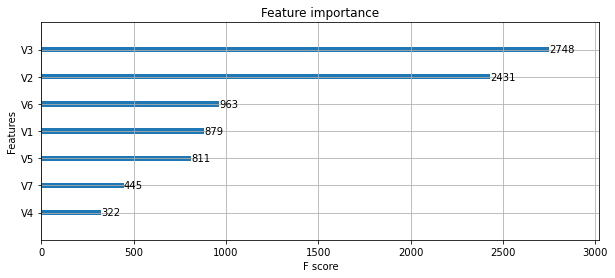

In [18]:
# check which features are important, just because
fig, ax = plt.subplots(figsize=(10, 4));
plot_importance(clf, ax=ax);

In [19]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    preds = clf.predict(df)

    promotion_df = []
    for pred in preds:
        if pred == 1:
            promotion_df.append('Yes')
        else:
            promotion_df.append('No')
    promotion_df = np.array(promotion_df)
    return promotion_df

In [20]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0120.

Your nir with this strategy is -4.05.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.012037037037037034, -4.05)

**Results: Comments**

The model achieved an irr of 1.2% and a nir lost `$`4.05 on the test data.<br>
The Starbucks’ model got an IRR of 1.88% and a NIR of `$`189.45.<br>
I think I am good with this; I'll head out to Starbuck and give them the `$`4 lost.

u1up0ng 20200926